In [ ]:
# Basic libraries for data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tamer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from datasets import load_dataset

# Download the "civil_comments" dataset from Hugging Face
dataset = load_dataset("google/civil_comments")

print(dataset['train'][0])


C:\Users\tamer\anaconda3\envs\toxicity-dl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!", 'toxicity': 0.0, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.0, 'identity_attack': 0.0, 'sexual_explicit': 0.0}


In [ ]:
# Columns
print(dataset['train'].column_names)

['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']


In [ ]:
# Show first 5 lines of data
df = pd.DataFrame(dataset['train'])
df.head() 

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


In [ ]:
# Text cleaning
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    # Remove numbers and special symbols
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

In [7]:
print(dataset['train']['text'][0])

This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!


In [8]:
print(df['text'][0])

This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!


In [9]:
df['text'] = df['text'].map(lambda x: clean_text(x))

In [10]:
print(df['text'][0])

cool like would want mother read really great idea well done


In [ ]:
# Count the number of labels with a value of 1 for each row (comment).
df['num_labels'] = df[['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']].sum(axis=1)

# Number of comments containing more than one label
multi_label_comments = df[df['num_labels'] > 1]
print(f"Number of comments containing more than one label: {len(multi_label_comments)}")


عدد التعليقات التي تحتوي على أكثر من label: 160669


In [ ]:
# تعليقات تحتوي على أي شكل من السمية (أي label واحد أو أكثر)
toxic_comments = df[df['num_labels'] >= 1]
print(f"Number of toxic comments: {len(toxic_comments)}")

عدد التعليقات السامة: 168148


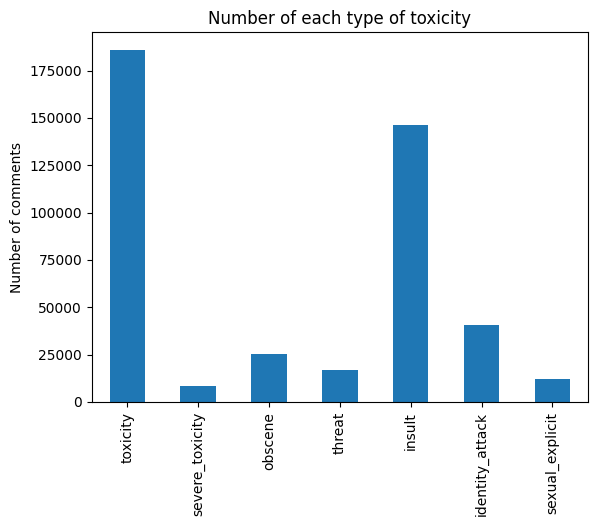

In [13]:
import matplotlib.pyplot as plt

label_counts = df[['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']].sum()

label_counts.plot(kind='bar', title='Number of each type of toxicity', ylabel='Number of comments')
plt.show()

In [14]:
#Analysis of the most common types of toxicity
label_columns = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
label_counts = df[label_columns].sum().sort_values(ascending=False).round(2)
label_ratios = (label_counts / len(df)) * 100

summary = pd.DataFrame({
    'Total': label_counts,
    'Ratio (%)': label_ratios.round(2)
})

print(summary)

                     Total  Ratio (%)
toxicity         185933.24      10.30
insult           146470.46       8.12
identity_attack   40854.61       2.26
obscene           25046.61       1.39
threat            16805.67       0.93
sexual_explicit   11922.95       0.66
severe_toxicity    8270.11       0.46


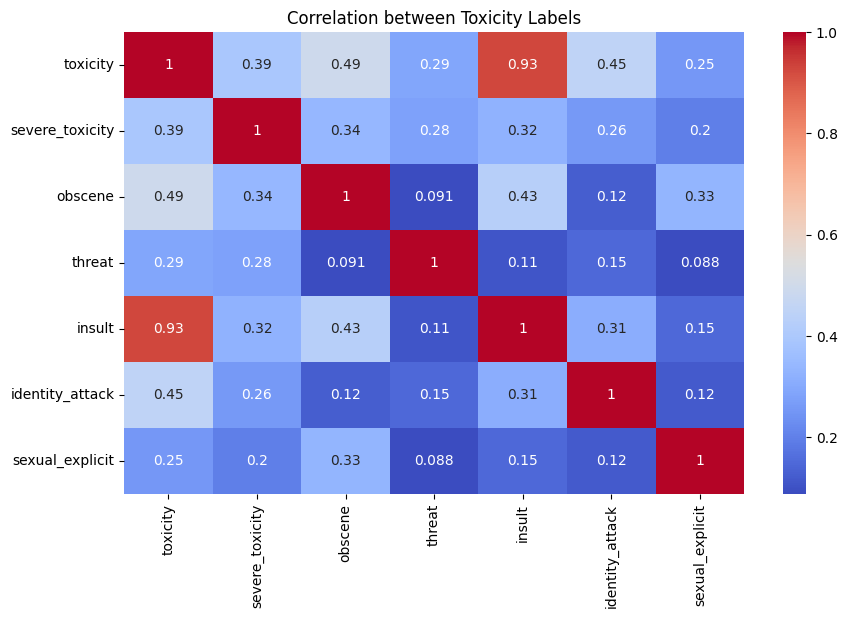

In [15]:
#Correlation analysis
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(df[label_columns].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Toxicity Labels")
plt.show()

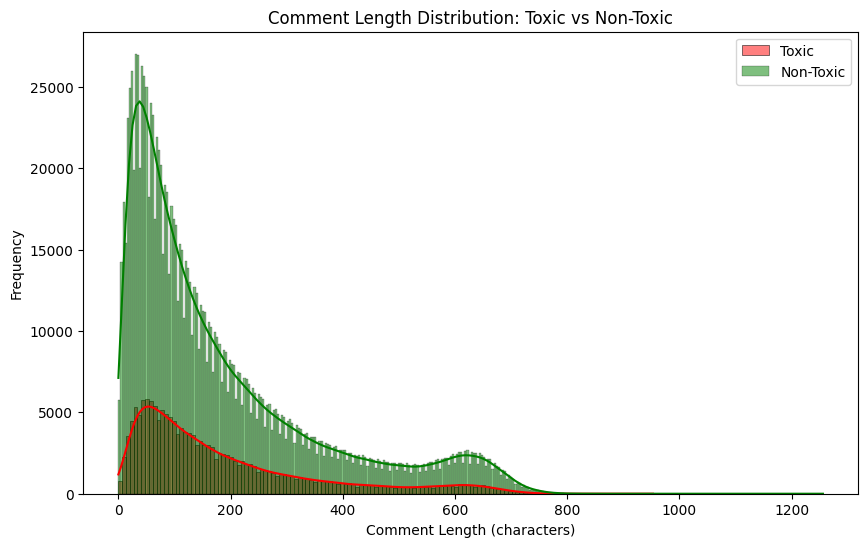

In [16]:
#Comment length distribution
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df[df[label_columns].sum(axis=1) >= 1]['text_length'], color='red', label='Toxic', kde=True)
sns.histplot(df[df[label_columns].sum(axis=1) == 0]['text_length'], color='green', label='Non-Toxic', kde=True)
plt.legend()
plt.title("Comment Length Distribution: Toxic vs Non-Toxic")
plt.xlabel("Comment Length (characters)")
plt.ylabel("Frequency")
plt.show()


In [18]:
#Show examples of toxic comments
for label in ['toxicity', 'obscene', 'insult']:
    print(f"\nExamples for label: {label}")
    print(df[df[label] == 1]['text'].sample(3).to_list())



Examples for label: toxicity
['many impeachable offenses aclown know gop politicians gutless given semblance morals ethics guess wait democrats flip houses longer joke president allowed run around clueless unfettered worse world country yes republican party insanity growing worse every day anyone half brain see boy scout speech tweets', 'mr trump answer mustve pretty dumb question', 'wouldnt need april st find fool subject article']

Examples for label: obscene
['morneau correct doesnt report journalists personal situation public official one highest land better prepared answer questions pleasant otherwise free press final backstop democracy country morneau sign democratic process entails answered trudeaus call serve stop whining sounding damn trumplike face music man right thing', 'darn loss', 'know need smart president knows words lots words went ivy league school im highly educated know words best wordsbut better word stupid right drumpf president']

Examples for label: insult
['st